In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as scstats
import matplotlib.pyplot as plt


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
! pip3 install pybind11
! pip3 install cppimport

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
! git clone https://github.com/RLovelett/eigen.git

fatal: destination path 'eigen' already exists and is not an empty directory.


**Exercise 1 (20 points)**

Implement a function that returns $n$ samples from a multivariate Gaussian distribution in C++ and wrap it for use in Python using `pybind11`. Use only standard C++ and the `Eigen` library. The function signature in Python  is

```python
def mvnorm(mu, Sigma, n):
    """Returns n random samples from a multivariate Gaussian distribution.
    
    mu is a mean vector
    Sigma is a covariance matrix
    
    Returns an n by p matrix, where p is the dimension of the distribution.
    """
```

In [4]:
%mkdir q1
%cd q1

mkdir: cannot create directory ‘q1’: File exists
/home/jovyan/work/sta-663-2017/homework/q1


In [5]:
%%file wrapq1.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../eigen']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>
#include <random>
#include <Eigen/LU>
#include <Eigen/Dense>
#include <Eigen/Cholesky> 
#include <iostream>

using std::cout;
using std::endl;

namespace py = pybind11;

Eigen::MatrixXd mvnorm(Eigen::MatrixXd mu,Eigen::MatrixXd Sigma, int n) {
   
    int n_cols=Sigma.cols();
    Eigen::MatrixXd chol=Sigma.llt().matrixL();
    Eigen::MatrixXd Y(n,n_cols);
            
            
    std::default_random_engine generator;
    std::normal_distribution<double> distribution(0.0,1.0);        
            
    for (int i = 0; i < n; i++ ) {
        for (int j = 0; j < n_cols; j++ )  {      
            Y(i,j)=distribution(generator);
            }
        }
  
    return mu.replicate(1,n).transpose()+Y*chol;
}

PYBIND11_PLUGIN(wrapq1) {
    pybind11::module m("wrapq1", "auto-compiled c++ extension");
    m.def("mvnorm", &mvnorm);
    return m.ptr();
}

Overwriting wrapq1.cpp


In [6]:
import cppimport
import numpy as np

code = cppimport.imp("wrapq1")

sig = np.array([[1,0],
              [0,1]])
mean = np.array([0,0])

#test
print(code.mvnorm(mean,sig,10))

[[-0.12196578 -1.08681804]
 [ 0.68428994 -1.07518915]
 [ 0.03326948  0.7448356 ]
 [ 0.03360612 -0.52663721]
 [ 0.46253204  0.20069944]
 [ 2.12467668  0.37172123]
 [ 1.02096273  0.78340821]
 [-0.12784189 -0.33681328]
 [-0.68715483  1.30842096]
 [-0.93584189 -2.67236586]]


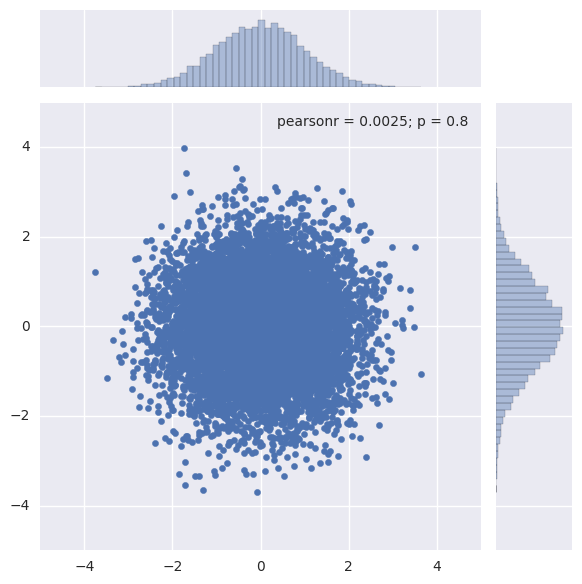

In [22]:
import seaborn as sns
#Plot draws from bivariate normal with mu=[1,1] and var=[1,0],[0,1]

#From glancing at the plot, the mean and variance look reasonable
bivar=code.mvnorm(mean,sig,10000)
sns.jointplot(bivar[:,0],bivar[:,1],kind='scatter')


**Exercise 2 (20 points)**

- Consider a sequence of $n$ Bernoulli trials with success probability $p$ per trial. A string of consecutive successes is known as a success *run*. Write a function that returns the counts for runs of length $k$ for each $k$ observed in a dictionary.

For example: if the trials were [0, 1, 0, 1, 1, 0, 0, 0, 0, 1], the function should return 
```
{1: 2, 2: 1})
```

- What is the probability of observing at least one run of length 5 or more when $n=100$ and $p=0.5$?. Estimate this from 100,000 simulated experiments. Is this more, less or equally likely than finding runs of length 7 or more when $p=0.7$?

In [8]:
def count(runs):
    """Function that returns the counts for runs of length k for each k observed in a dictionary"""
    
    #initalize dictionary 
    d={}
    
    #initialize counter 
    counter = 0
    
    #iterate through each trial 
    for trial in runs:
        
        #add to counter if it was a scucess 
        if trial == 1:
            counter = counter+1    
            
        #if not a success, add to dictionary and then restart the counter 
        else:
            if counter!=0:
                d[counter] = d.get(counter, 0) + 1
            counter = 0
            
    if counter!=0: 
        d[counter] = d.get(counter, 0) + 1
        
    #return the dictionary 
    return d

In [9]:
trial= [0, 1, 0, 1, 1, 0, 0, 0, 0, 1]
count(trial)

{1: 2, 2: 1}

In [10]:
#What is the probability of observing at least one run of length 5 or more when n=100n=100 and  p=0.5

trials=np.random.choice([0,1], (100000, 100), p=(0.5, 0.5))
trials_dicts=map(count,trials)

print("Probability of Observing at least one run of length 5 or more with p=0.5:")
print(sum(max(d.keys())>=5 for d in trials_dicts)/100000)


Probability of Observing at least one run of length 5 or more with p=0.5:
0.81243


In [11]:
# runs of length 7 or more when  p=0.7

trials=np.random.choice([0,1], (100000, 100), p=(0.3, 0.7))
trials_dicts=map(count,trials)

print("Probability of Observing at least one run of length 7 or more with p=0.7:")
print(sum(max(d.keys())>=7 for d in trials_dicts)/100000)
print("\nIt is more likely to observe at least one run of length 7 or more with p=0.7")

Probability of Observing at least one run of length 7 or more with p=0.7:
0.95026

It is more likely to observe at least one run of length 7 or more with p=0.7


**Exercise 3 (20 points)**.

- Consider an unbiased random walk of length $n$ as simulated with a sequence of -1 or +1 values. If we start from 0, plot the distribution of *last* return times for 100,000 simulations with $n = 100$. The last return time is the last time the cumulative sum of the random walk is zero - this may be the starting point if the walk never returns to zero in 100 steps. 

- Do a maximum likeliood fit of a beta distribution to the set of last return times using the `beta.fit()` function from `scipy.stats`. Set the lower bound (loc) = 0 and the upper bound (scale) = 100 for plotting. Superimpose the fitted beta PDF on the normalized histogram of last reutrn times.

(array([ 21997.,   8705.,   7300.,   6573.,   6205.,   6371.,   6618.,
          7395.,   8969.,  19867.]),
 array([  0. ,   9.9,  19.8,  29.7,  39.6,  49.5,  59.4,  69.3,  79.2,
         89.1,  99. ]),
 <a list of 10 Patch objects>)

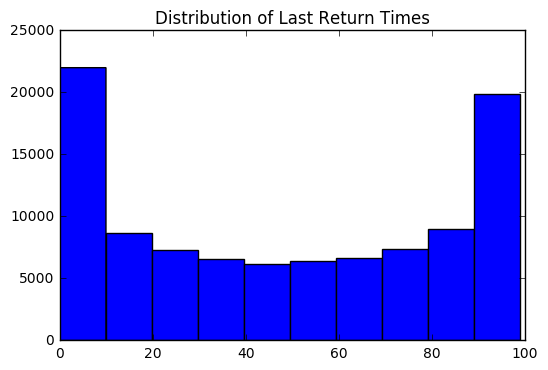

In [12]:
#unbiased random walk function 
random_walks=np.zeros([100000,100])
    
for i in range(100):
    #create random walk with 
    new=np.random.choice([-1,1], 100000, p=(0.5, 0.5))
    random_walks[:,(i)]=new


last_zero=np.zeros(100000)

#find the last return time 
for i in range(100):
    window=random_walks[:,0:(i+1)]
    
    sums=np.sum(window,axis=1)
    last_zero[sums==0]=i
   
plt.title("Distribution of Last Return Times")
plt.hist(last_zero)

In [13]:
#maximum likeliood, use beta.fit
beta_fit=scstats.beta.fit(last_zero,loc=0,scale=100)

(array([ 0.02221919,  0.00879293,  0.00737374,  0.00663939,  0.00626768,
         0.00643535,  0.00668485,  0.0074697 ,  0.0090596 ,  0.02006768]),
 array([  0. ,   9.9,  19.8,  29.7,  39.6,  49.5,  59.4,  69.3,  79.2,
         89.1,  99. ]),
 <a list of 10 Patch objects>)

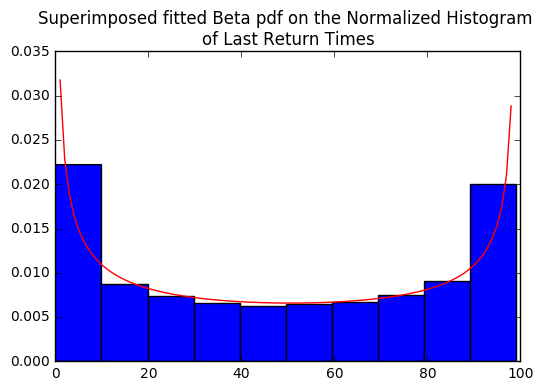

In [14]:
#Superimpose the fitted beta PDF on the normalized histogram
x=np.linspace(0,100,100)
plt.title("Superimposed fitted Beta pdf on the Normalized Histogram \nof Last Return Times")
plt.plot(scstats.beta.pdf(x,a=beta_fit[0],b=beta_fit[1],scale=100,loc=0),color="red")
plt.hist(last_zero,normed=True)

**Exercise 4 (20 points)**

The Cauchy distribution is given by 
$$
f(x) = \frac{1}{\pi (1 + x^2)}, \ \ -\infty \lt x \lt \infty 
$$

- Integrate the tail probability $P(X > 2)$ using Monte Carlo
    1. Sampling from the Cauchy distribution directly
    2. Sampling from the uniform distribution using an appropriate change of variables
- Plot the 95% CI for the Monte Carlo estimates for n = 1 to 1000
    1. For sampling from the Cauchy distribution using mulitple Monte Carlo sequences
    2. For sampling from the uniform distribution using bootstrap samples of a single Monte Carlo sequence




In [15]:
n=100000

#Estimate sampling from Cauchy
print("P(X > 2) estimated by drawing directly from Cauchy")
print(sum(np.random.standard_cauchy(n)>2)/n)

P(X > 2) estimated by drawing directly from Cauchy
0.1485


In [16]:
#Estimate by sampling from uniform
y = np.random.uniform(size=(n,1))
print("P(X > 2) estimated by changing variables and sampling from Uniform Dist.")
print(1.0/n * np.sum(2.0/(np.pi * (4 + y**2))))

P(X > 2) estimated by changing variables and sampling from Uniform Dist.
0.147562656431


In [17]:
#For sampling from the Cauchy distribution using mulitple Monte Carlo sequences
n=list(range(1000))
upper=np.ones(1000)
lower=np.ones(1000)
answer=np.ones(1000)

for i in range(1000):
    #choose each value for n
    current_n=n[i]+1
    
    #calculate the estimate 
    current=np.mean(np.random.standard_cauchy(size=(current_n,1000))>2,axis=0)
    
    #store mean and desired percentiles
    answer[i]=np.mean(current)
    lower[i]=np.percentile(current,2.5)
    upper[i]=np.percentile(current,97.5)



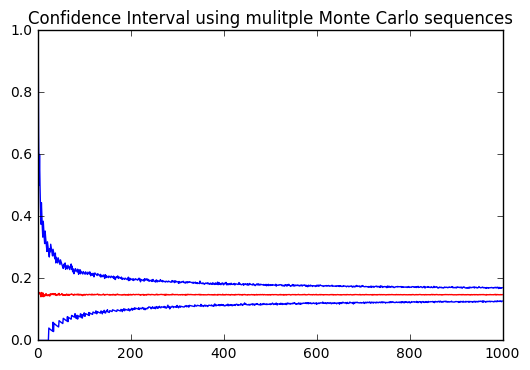

In [18]:
#plot the confidence intervals 
plt.plot(n, answer, c='red', linewidth=1);
plt.title('Confidence Interval using mulitple Monte Carlo sequences')
plt.plot(n, upper, 'b',n, lower, 'b')
pass

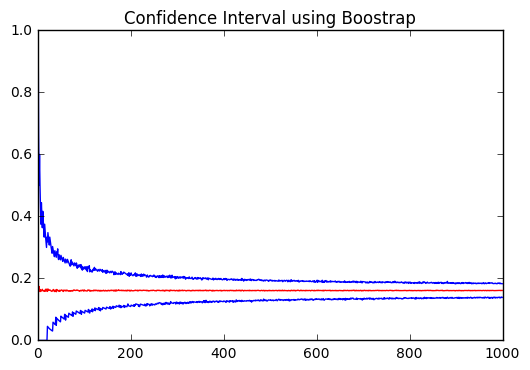

In [19]:
#For sampling from the uniform distribution using bootstrap samples of a single Monte Carlo sequence
reps=1000

upper2=np.ones(1000)
lower2=np.ones(1000)
answer2=np.ones(1000)
n=list(range(1000))

#draw from cauchy
values=np.random.standard_cauchy(size=1000)>2



for i in range(1000):
    
    #sample with replacment 
    current=  np.mean(np.random.choice(values, (i+1, reps), replace=True),axis=0)  
    
    #update lists
    answer2[i]=np.mean(current)
    lower2[i]=np.percentile(current,2.5)
    upper2[i]=np.percentile(current,97.5)


#plot the confidence intervals 
plt.plot(n, answer2, c='red', linewidth=1);
plt.title('Confidence Interval using Boostrap')
plt.plot(n, upper2, 'b',n, lower2, 'b')
pass


**Exercise 5 (20 points)**.

Estimate the following integral using Monte Carlo integration

$$
\int_{-\infty}^{\infty} x^2 \frac{1}{2}e^{-|x|} dx
$$

Hint: See notes on importance sampling and figure.

![Hint](./dexp.png)

In [20]:
## Use N(0,2) as the importance function

#draw h values
h_values=np.random.normal(0,2,(1000000,1))

#evaluate 
print("Estimate of Integral with Importance Sampling")
print(np.mean((h_values**2*0.5*np.exp(-np.abs(h_values)))/scstats.norm.pdf(h_values,0,2)))


Estimate of Integral with Importance Sampling
1.99774249614
